In [1]:
import numpy as np

# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
odor_source = np.array([[24, 0, 1.5], [8, -4, 1.5]]) #, [16, 4, 1.5]])

# Peak intensities: array of shape (num_odor_sources, odor_dimesions)
# For each odor source, if the intensity is (x, 0) then the odor is in the 1st dimension
# (in this case attractive). If it's (0, x) then it's in the 2nd dimension (in this case
# aversive)
peak_intensity = np.array([[1, 0], [0, 1]]) #, [0, 1]])

# Marker colors: array of shape (num_odor_sources, 4) - RGBA values for each marker,
# normalized to [0, 1]
#marker_colors = [[255, 127, 14], [31, 119, 180], [31, 119, 180]]
#marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])

odor_dimesions = len(peak_intensity[0])

odor_valence = [1,2]

In [2]:
from flygym.mujoco.arena import OdorArena

arena = OdorArena(
     odor_source=odor_source,
     peak_intensity=peak_intensity,
     odor_valence=odor_valence,
     diffuse_func=lambda x: x**-2,
     marker_size=0.3,
 )

pygame 2.5.2 (SDL 2.28.3, Python 3.8.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


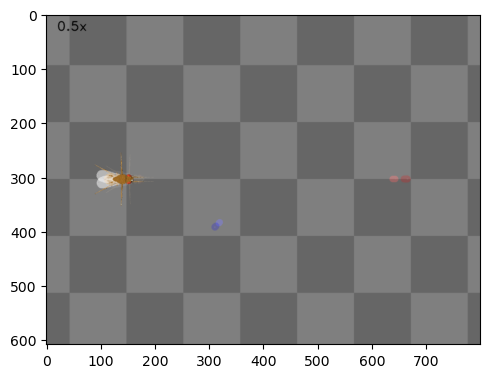

In [3]:
import matplotlib.pyplot as plt
from flygym.mujoco import Parameters
from flygym.mujoco.examples.turning_controller import HybridTurningNMF


contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]
sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.5,
    render_window_size=(800, 608),
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False,
    render_camera="birdeye_cam",
)
sim = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
)
for i in range(1):
    sim.step(np.zeros(2))
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(sim._frames[-1])
ax.axis("on")
fig.savefig("./outputs/olfaction_env.png") 

In [4]:
sim.curr_time

0.0001

In [51]:
from tqdm import trange

attractive_gain = 10
aversive_gain = -200
decision_interval = 0.05
run_time = sim.simulation_time
num_decision_steps = int(run_time / decision_interval)
physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)

"""obs_hist = []
odor_history = []
obs, _ = sim.reset()"""
_, _ = sim.reset()
for i in trange(num_decision_steps):
    attractive_intensities = np.average(
        obs["odor_intensity"][0, :].reshape(2, 2), axis=0, weights=[9, 1]
    )
    aversive_intensities = np.average(
        obs["odor_intensity"][1, :].reshape(2, 2), axis=0, weights=[10, 0]
    )
    attractive_bias = (
        attractive_gain
        * (attractive_intensities[0] - attractive_intensities[1])
        / attractive_intensities.mean()
    )
    aversive_bias = (
        aversive_gain
        * (aversive_intensities[0] - aversive_intensities[1])
        / aversive_intensities.mean()
    )
    effective_bias = aversive_bias + attractive_bias
    effective_bias_norm = np.tanh(effective_bias**2) * np.sign(effective_bias)
    assert np.sign(effective_bias_norm) == np.sign(effective_bias)

    control_signal = np.ones((2,))
    side_to_modulate = int(effective_bias_norm > 0)
    modulation_amount = np.abs(effective_bias_norm) * 0.8
    control_signal[side_to_modulate] -= modulation_amount

    for j in range(physics_steps_per_decision_step):
        obs, reward, terminated, truncated, _ = sim.step(control_signal)
        rendered_img = sim.render()
        if rendered_img is not None:
            # record odor intensity too for video
            odor_history.append(obs["odor_intensity"])
        obs_hist.append(obs)
    
        if reward != None:
            break
        if terminated:
            break
        if truncated:
            break
        
        

"""    # Stop when the fly is within 2mm of the attractive odor source
    if np.linalg.norm(obs["fly"][0, :2] - odor_source[1, :2]) < 2:
        break
    if np.linalg.norm(obs["fly"][0, :2] - odor_source[2, :2]) < 2:
        break"""

100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


'    # Stop when the fly is within 2mm of the attractive odor source\n    if np.linalg.norm(obs["fly"][0, :2] - odor_source[1, :2]) < 2:\n        break\n    if np.linalg.norm(obs["fly"][0, :2] - odor_source[2, :2]) < 2:\n        break'

In [52]:
print(sim.curr_time)
print(sim.fly_valence_dictionary)

1.6455999999998352
{-1: 2}


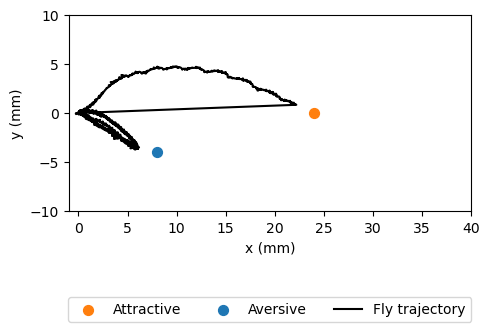

In [53]:
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [odor_source[0, 0]],
    [odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Attractive",
)
ax.scatter(
    [odor_source[1, 0]],
    [odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Aversive",
)
#ax.scatter([odor_source[2, 0]], [odor_source[2, 1]], marker="o", color="tab:blue", s=50)
ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory")
ax.set_aspect("equal")
ax.set_xlim(-1, 40)
ax.set_ylim(-10, 10)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
#fig.savefig("./outputs/odor_taxis_trajectory.png")

In [25]:
sim.fly_valence_dictionary

{-1: 2}

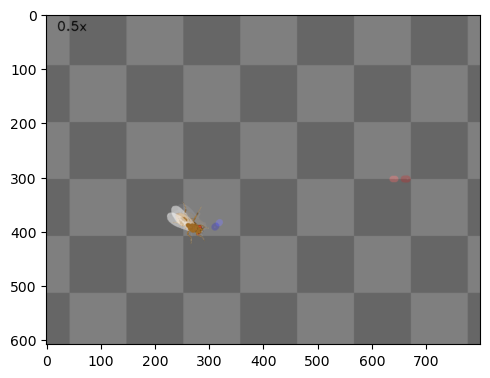

In [26]:
for i in range(10):
    sim.step(np.zeros(2))
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(sim._frames[-1])
ax.axis("on")
fig.savefig("./outputs/olfaction_env.png") 

In [44]:
from tqdm import trange

attractive_gain = -500
aversive_gain = 100
decision_interval = 0.05
run_time = sim.simulation_time
num_decision_steps = int(run_time / decision_interval)
physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)

"""obs_hist = []
odor_history = []
obs, _ = sim.reset()"""
_, _ = sim.reset()
for i in trange(num_decision_steps):
    attractive_intensities = np.average(
        obs["odor_intensity"][0, :].reshape(2, 2), axis=0, weights=[9, 1]
    )
    aversive_intensities = np.average(
        obs["odor_intensity"][1, :].reshape(2, 2), axis=0, weights=[10, 0]
    )
    attractive_bias = (
        attractive_gain
        * (attractive_intensities[0] - attractive_intensities[1])
        / attractive_intensities.mean()
    )
    aversive_bias = (
        aversive_gain
        * (aversive_intensities[0] - aversive_intensities[1])
        / aversive_intensities.mean()
    )
    effective_bias = aversive_bias + attractive_bias
    effective_bias_norm = np.tanh(effective_bias**2) * np.sign(effective_bias)
    assert np.sign(effective_bias_norm) == np.sign(effective_bias)

    control_signal = np.ones((2,))
    side_to_modulate = int(effective_bias_norm > 0)
    modulation_amount = np.abs(effective_bias_norm) * 0.8
    control_signal[side_to_modulate] -= modulation_amount

    for j in range(physics_steps_per_decision_step):
        obs, reward, terminated, truncated, _ = sim.step(control_signal)
        rendered_img = sim.render()
        if rendered_img is not None:
            # record odor intensity too for video
            odor_history.append(obs["odor_intensity"])
        obs_hist.append(obs)
    
        if reward != None:
            break
        if terminated:
            break
        if truncated:
            break

100%|██████████| 100/100 [05:48<00:00,  3.49s/it]


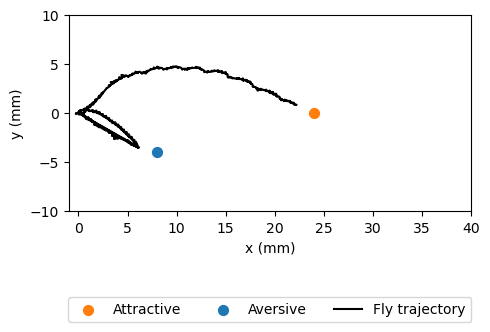

In [46]:
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [odor_source[0, 0]],
    [odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Attractive",
)
ax.scatter(
    [odor_source[1, 0]],
    [odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Aversive",
)
#ax.scatter([odor_source[2, 0]], [odor_source[2, 1]], marker="o", color="tab:blue", s=50)
ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory")
ax.set_aspect("equal")
ax.set_xlim(-1, 40)
ax.set_ylim(-10, 10)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
#fig.savefig("./outputs/odor_taxis_trajectory.png")

**RESPAWN AND RETRAIN**

In [9]:
arena = OdorArena(
     odor_source=odor_source,
     peak_intensity=peak_intensity,
     odor_valence=odor_valence,
     diffuse_func=lambda x: x**-2,
     marker_size=0.3,
 )

In [11]:
print(sim.curr_time)

1.7427999999998245


In [12]:
sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.5,
    render_window_size=(800, 608),
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False,
    render_camera="birdeye_cam",
)
sim2 = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
    fly_valence_dictionary=sim.fly_valence_dictionary,
    elapsed_time=sim.elapsed_time

)

In [20]:
sim2.fly_valence_dictionary

{-1: 2}

In [14]:
from tqdm import trange

attractive_gain = -500
aversive_gain = 100
decision_interval = 0.05
run_time = sim.simulation_time
num_decision_steps = int(run_time / decision_interval)
physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)

obs_hist = []
odor_history = []
obs, _ = sim.reset()
for i in trange(num_decision_steps):
    attractive_intensities = np.average(
        obs["odor_intensity"][0, :].reshape(2, 2), axis=0, weights=[9, 1]
    )
    aversive_intensities = np.average(
        obs["odor_intensity"][1, :].reshape(2, 2), axis=0, weights=[10, 0]
    )
    attractive_bias = (
        attractive_gain
        * (attractive_intensities[0] - attractive_intensities[1])
        / attractive_intensities.mean()
    )
    aversive_bias = (
        aversive_gain
        * (aversive_intensities[0] - aversive_intensities[1])
        / aversive_intensities.mean()
    )
    effective_bias = aversive_bias + attractive_bias
    effective_bias_norm = np.tanh(effective_bias**2) * np.sign(effective_bias)
    assert np.sign(effective_bias_norm) == np.sign(effective_bias)

    control_signal = np.ones((2,))
    side_to_modulate = int(effective_bias_norm > 0)
    modulation_amount = np.abs(effective_bias_norm) * 0.8
    control_signal[side_to_modulate] -= modulation_amount

    for j in range(physics_steps_per_decision_step):
        obs, reward, terminated, truncated, _ = sim2.step(control_signal)
        rendered_img = sim2.render()
        if rendered_img is not None:
            # record odor intensity too for video
            odor_history.append(obs["odor_intensity"])
        obs_hist.append(obs)
    
        if reward != None:
            break
        if terminated:
            break
        if truncated:
            break

100%|██████████| 100/100 [03:55<00:00,  2.35s/it]


In [15]:
sim2.fly_valence_dictionary

{-1: 2}

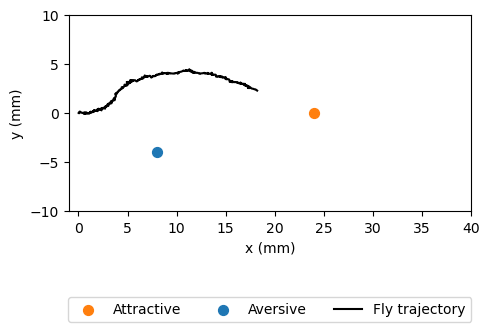

In [21]:
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [odor_source[0, 0]],
    [odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Attractive",
)
ax.scatter(
    [odor_source[1, 0]],
    [odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Aversive",
)
#ax.scatter([odor_source[2, 0]], [odor_source[2, 1]], marker="o", color="tab:blue", s=50)
ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory")
ax.set_aspect("equal")
ax.set_xlim(-1, 40)
ax.set_ylim(-10, 10)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
#fig.savefig("./outputs/odor_taxis_trajectory.png")

**TRYING TO RESWPAN, DOES NOT WORK, MODEL CANNOT BE ATTACHED TWICE**

In [ ]:
def is_truncated(truncated, obs, sim):
    if truncated:
        arena.spawn_entity(sim.model, sim.spawn_pos, sim.spawn_orientation)
    else:
        print("fly position", obs["fly"][0, :2])
        print(arena.size)

In [ ]:
from tqdm import trange

attractive_gain = 10
aversive_gain = -200
decision_interval = 0.05
run_time = 5
num_decision_steps = int(run_time / decision_interval)
physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)

obs_hist = []
odor_history = []
obs, _ = sim.reset()
for i in trange(num_decision_steps):
    attractive_intensities = np.average(
        obs["odor_intensity"][0, :].reshape(2, 2), axis=0, weights=[9, 1]
    )
    aversive_intensities = np.average(
        obs["odor_intensity"][1, :].reshape(2, 2), axis=0, weights=[10, 0]
    )
    attractive_bias = (
        attractive_gain
        * (attractive_intensities[0] - attractive_intensities[1])
        / attractive_intensities.mean()
    )
    aversive_bias = (
        aversive_gain
        * (aversive_intensities[0] - aversive_intensities[1])
        / aversive_intensities.mean()
    )
    effective_bias = aversive_bias + attractive_bias
    effective_bias_norm = np.tanh(effective_bias**2) * np.sign(effective_bias)
    assert np.sign(effective_bias_norm) == np.sign(effective_bias)

    control_signal = np.ones((2,))
    side_to_modulate = int(effective_bias_norm > 0)
    modulation_amount = np.abs(effective_bias_norm) * 0.8
    control_signal[side_to_modulate] -= modulation_amount

    for j in range(physics_steps_per_decision_step):
        obs, _, _, _, _ = sim.step(control_signal)
        rendered_img = sim.render()
        if rendered_img is not None:
            # record odor intensity too for video
            odor_history.append(obs["odor_intensity"])
        obs_hist.append(obs)
        truncated = True
        is_truncated(truncated, obs, sim)
          
    
            
        

In [ ]:
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [odor_source[0, 0]],
    [odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Attractive",
)
ax.scatter(
    [odor_source[1, 0]],
    [odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Aversive",
)
#ax.scatter([odor_source[2, 0]], [odor_source[2, 1]], marker="o", color="tab:blue", s=50)
ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory")
ax.set_aspect("equal")
ax.set_xlim(-1, 40)
ax.set_ylim(-5, 5)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
#fig.savefig("./outputs/odor_taxis_trajectory.png")

In [54]:
sim.save_video("./outputs/odor_taxis_miple.mp4")

: 

In [50]:
sim.fly_valence_dictionary

{-1: 2}

**RANDOM**

In [ ]:
def get_reward(obs):
    """Get the reward for the current state of the environment"""
    truncated = False
    reward = 0
    for i in range(len(arena.odor_source)):
        #if fly is within 2mm of the attractive odor source
        if np.linalg.norm(obs["fly"][0, :2] - arena.odor_source[i, :2]) < 2:
            #the fly gets the reward
            smell_key_value = arena.compute_smell_key_value(arena.peak_odor_intensity[i])
            reward = arena.valence_dictionary.get(smell_key_value)
            sim.fly_valence_dictionary.update(({smell_key_value: reward}))
            truncated = True
        #print("smell", i)
        print(truncated)
        if truncated:
            break#return reward, truncated

In [ ]:
def is_truncated(obs, arena):
    sources_far_away = 0
    for i in range(len(arena.odor_source)):
            # if fly is at least 30 mm away from any odor source  
        if np.linalg.norm(obs["fly"][0, :2] - arena.odor_source[i, :2]) > 30:
            sources_far_away+=1
        #if fly is away from all sources
    if sources_far_away == len(arena.odor_source):
        return True
    return False